In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


---
### simple_diarizer 사용법과 오류 해결

설치해준다..

In [2]:
!pip install simple_diarizer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 760.1/760.1 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 41.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 52.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 69.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━

In [3]:
%%capture
# Installing SpeechBrain via pip
BRANCH = 'develop'
!python -m pip install git+https://github.com/speechbrain/speechbrain.git@$BRANCH

speechbrain 예제에서 긁어온 임포트 문이랑 모델 불러오는 형식 참고용


```
from speechbrain.inference.classifiers import EncoderClassifier

model = separator.from_hparams(source="speechbrain/sepformer-wsj02mix", savedir='pretrained_models/sepformer-wsj02mix')
est_sources = model.separate_file(path=WAV_FILE)
```





---



In [5]:
from simple_diarizer.diarizer import Diarizer
from simple_diarizer.utils import (check_wav_16khz_mono, convert_wavfile,
                                   waveplot, combined_waveplot, waveplot_perspeaker)

import os
import tempfile
from pprint import pprint

import matplotlib.pyplot as plt
import soundfile as sf

from IPython.display import Audio, display, HTML
from tqdm.autonotebook import tqdm


위 코드를 실행할때 오류가 나는데, diarizer.py파일에서 speechbrain.pretrained를 임포트하는 부분의 줄(line 9)을 아래로 바꾼다


```
from speechbrain.inference.classifiers import EncoderClassifier
```

이건 speechbrain 코드가 바뀌면서 생긴 호환 문제..

<br>

근데 여기서 simple-diarizer을 사용할때는

pip install simple-diarizer로 설치해서 사용하므로

그게 아닌 git clone이라던지의 방법으로 사용해야 할 것 같다.

### 오디오 파일 변환

- Diarizer은 16kHz의 모노파일만 input으로 사용(다를시 샘플링이 섞여서 결과가 이상해짐)

In [66]:
from pydub import AudioSegment

def convert_to_mono_16k(input_file, output_file):
    # 오디오 파일 로드
    audio = AudioSegment.from_file(input_file)

    # 스테레오에서 모노로 변환
    audio = audio.set_channels(1)

    # 샘플링 레이트 16k로 변환
    audio = audio.set_frame_rate(16000)

    # WAV 파일로 저장
    audio.export(output_file, format="wav")

In [80]:
# 입력 및 출력 파일 경로 지정
input_file = "/content/drive/MyDrive/졸작/project_share/speechbrain/example_audio/apple.wav"
output_file = "/content/drive/MyDrive/졸작/project_share/speechbrain/example_audio/apple_mono.wav"

# 변환 함수 호출
convert_to_mono_16k(input_file, output_file)

---
### 예시1

In [86]:
WAV_FILE="/content/drive/MyDrive/졸작/project_share/speechbrain/example_audio/apple_mono.wav"
NUM_SPEAKERS=3

In [87]:
with tempfile.TemporaryDirectory() as outdir:

    signal, fs = sf.read(WAV_FILE)

    print(f"wav file: {WAV_FILE}")

    diar = Diarizer(
        embed_model='ecapa', # supported types: ['xvec', 'ecapa']
        cluster_method='sc', # supported types: ['ahc', 'sc']
        window=1.5, # size of window to extract embeddings (in seconds)
        period=0.75 # hop of window (in seconds)
    )

    # If using NUM_SPEAKERS
    segments = diar.diarize(WAV_FILE,
                            num_speakers=NUM_SPEAKERS,
                            outfile=f"{outdir}.rttm")


    ## If NUM_SPEAKERS is unknown
    # segments = diar.diarize(WAV_FILE,
    #                         num_speakers=None,
    #                         threshold=1e-1,
    #                         outfile=f"{outdir}.rttm")

wav file: /content/drive/MyDrive/졸작/project_share/speechbrain/example_audio/apple_mono.wav


Using cache found in /root/.cache/torch/hub/snakers4_silero-vad_master


Running VAD...
Splitting by silence found 2 utterances
Extracting embeddings...


Utterances:   0%|          | 0/2 [00:00<?, ?it/s]

Clustering to 3 speakers...
Cleaning up output...
Done!


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_spectral_embedding.py:248: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)


In [88]:
segments

[{'start': 0.194,
  'end': 1.2779375,
  'label': 0,
  'start_sample': 3104,
  'end_sample': 20447},
 {'start': 1.986,
  'end': 3.111,
  'label': 2,
  'start_sample': 31776,
  'end_sample': 49776},
 {'start': 3.111,
  'end': 3.861,
  'label': 0,
  'start_sample': 49776,
  'end_sample': 61776},
 {'start': 3.861,
  'end': 7.2619375,
  'label': 1,
  'start_sample': 61776,
  'end_sample': 116191}]

오리지널 음성파일

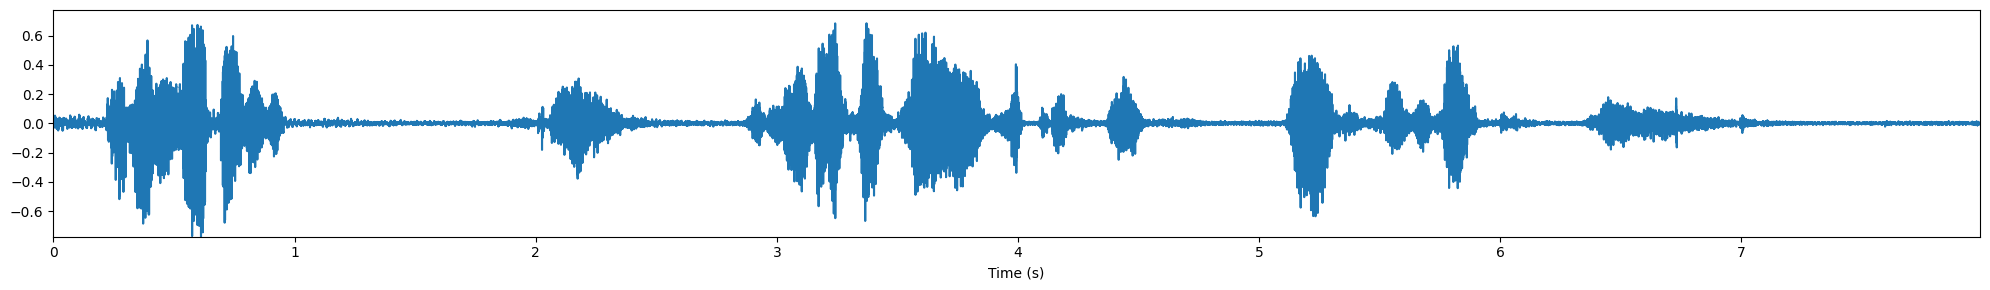

In [84]:
waveplot(signal, fs, figsize=(20,3))
plt.show()
Audio(signal.squeeze(), rate=fs)

세그먼트 화자별로 색깔 입혀서 출력

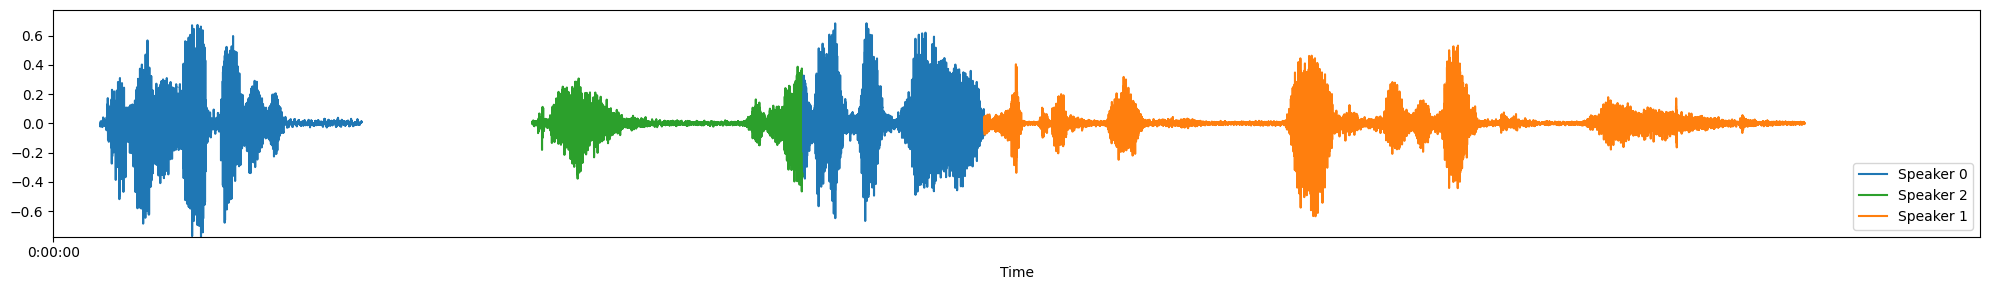

In [89]:
combined_waveplot(signal, fs, segments, figsize=(20,3), tick_interval=60)
plt.show()
Audio(signal.squeeze(), rate=fs)

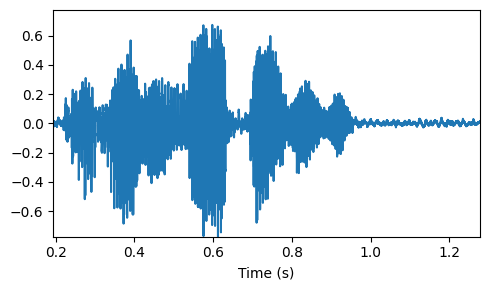

Speaker 0 (0.194s - 1.2779375s)


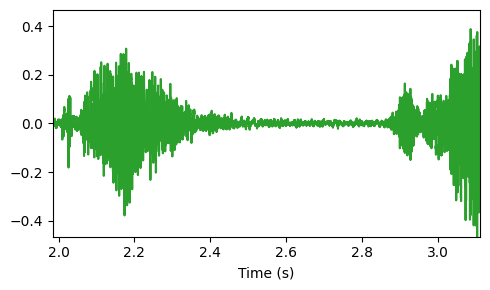

Speaker 2 (1.986s - 3.111s)


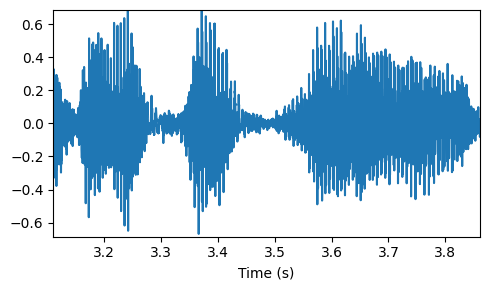

Speaker 0 (3.111s - 3.861s)


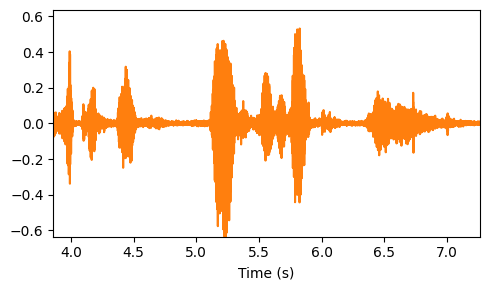

Speaker 1 (3.861s - 7.2619375s)


In [90]:
waveplot_perspeaker(signal, fs, segments)

---
### 예시2

In [114]:
# 입력 및 출력 파일 경로 지정
input_file = "/content/drive/MyDrive/졸작/project_share/speechbrain/example_audio/brawn.wav"
output_file = "/content/drive/MyDrive/졸작/project_share/speechbrain/example_audio/brawn_mono.wav"

# 변환 함수 호출
convert_to_mono_16k(input_file, output_file)

In [115]:
WAV_FILE="/content/drive/MyDrive/졸작/project_share/speechbrain/example_audio/brawn_mono.wav"
NUM_SPEAKERS=2

In [116]:
with tempfile.TemporaryDirectory() as outdir:

    signal, fs = sf.read(WAV_FILE)

    print(f"wav file: {WAV_FILE}")

    diar = Diarizer(
        embed_model='ecapa', # supported types: ['xvec', 'ecapa']
        cluster_method='ahc', # supported types: ['ahc', 'sc']
        window=1.5, # size of window to extract embeddings (in seconds)
        period=0.75 # hop of window (in seconds)
    )

    # If using NUM_SPEAKERS
    segments = diar.diarize(WAV_FILE,
                            num_speakers=NUM_SPEAKERS,
                            outfile=f"{outdir}.rttm")


    ## If NUM_SPEAKERS is unknown
    # segments = diar.diarize(WAV_FILE,
    #                         num_speakers=None,
    #                         threshold=1e-1,
    #                         outfile=f"{outdir}.rttm")

wav file: /content/drive/MyDrive/졸작/project_share/speechbrain/example_audio/brawn_mono.wav


Using cache found in /root/.cache/torch/hub/snakers4_silero-vad_master


Running VAD...
Splitting by silence found 3 utterances
Extracting embeddings...


Utterances:   0%|          | 0/3 [00:00<?, ?it/s]

Clustering to 2 speakers...
Cleaning up output...
Done!


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


오리지널 음성파일

세그먼트 화자별로 색깔 입혀서 출력


대사
```
Veronica Corningstone:"Mr Burgundy, you are acting like a baby."
Ron Burgundy:"I'm not a baby, I am a man! I am an anchorman!"
Veronica Corningstone:"You are not a man! You are a big fat joke!"
Ron Burgundy:"I'm a man who discovered the wheel and built the Eiffel Tower out of metal and brawn! That's what kind of man I am. You're just a woman with a small brain. With a brain a third the size of us. It's science."
```



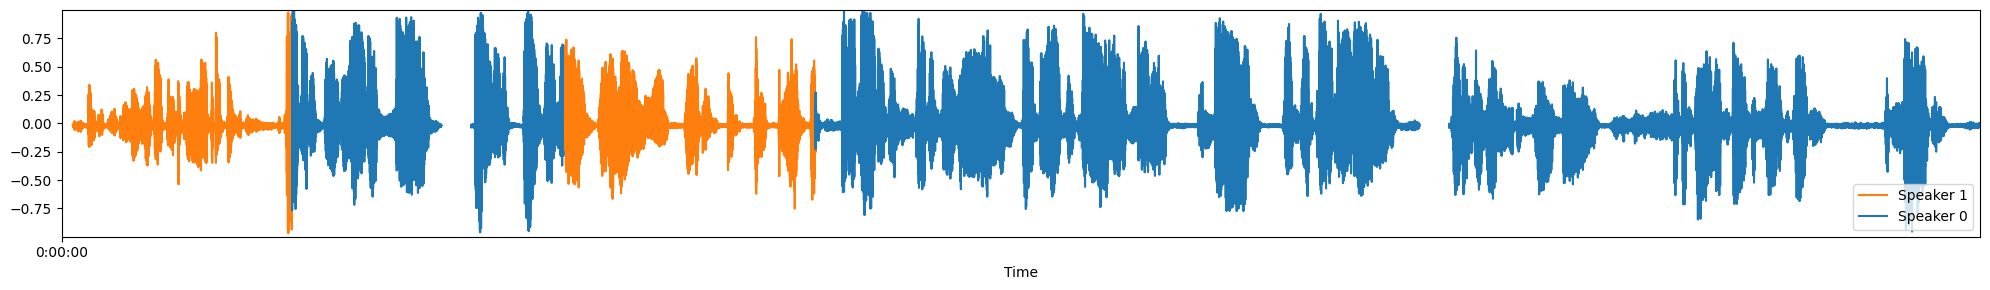

In [118]:
combined_waveplot(signal, fs, segments, figsize=(20,3), tick_interval=60)
plt.show()
Audio(signal.squeeze(), rate=fs)

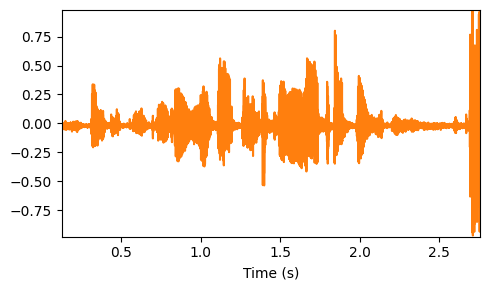

Speaker 1 (0.13s - 2.755s)


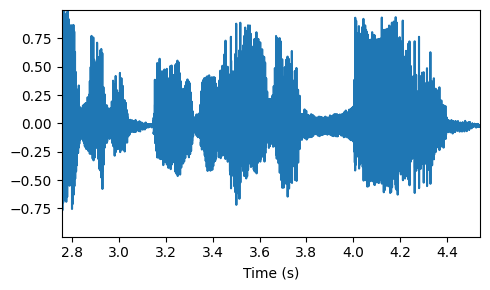

Speaker 0 (2.755s - 4.5419375s)


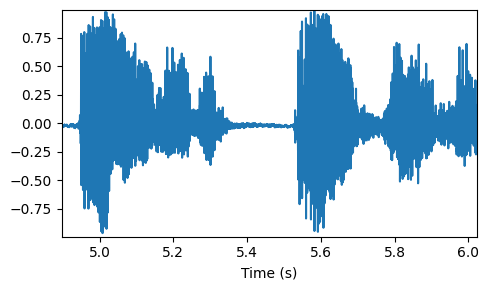

Speaker 0 (4.898s - 6.023s)


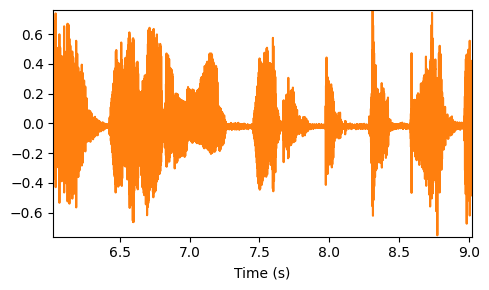

Speaker 1 (6.023s - 9.023s)


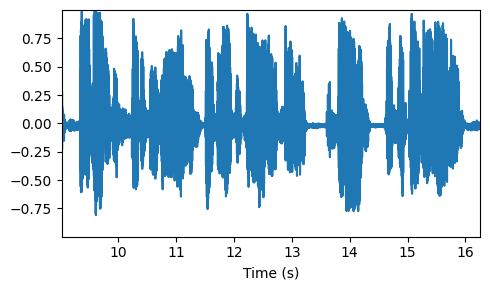

Speaker 0 (9.023s - 16.2539375s)


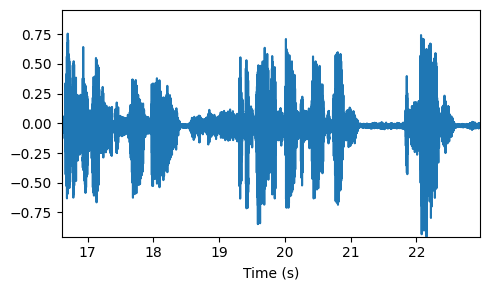

Speaker 0 (16.61s - 22.9679375s)


In [119]:
waveplot_perspeaker(signal, fs, segments)

---
### 예시3 : 잡음제거 + 추출

In [120]:
# 입력 및 출력 파일 경로 지정
input_file = "/content/drive/MyDrive/졸작/project_share/speechbrain/example_audio/hair.wav"
output_file = "/content/drive/MyDrive/졸작/project_share/speechbrain/example_audio/hair_mono.wav"

# 변환 함수 호출
convert_to_mono_16k(input_file, output_file)

In [133]:
WAV_FILE="/content/drive/MyDrive/졸작/project_share/speechbrain/example_audio/hair_mono.wav"
NUM_SPEAKERS=2

#### 잡음제거

In [122]:
from speechbrain.inference.separation import SepformerSeparation as separator
import torchaudio

model = separator.from_hparams(source="speechbrain/sepformer-whamr-enhancement", savedir='pretrained_models/sepformer-whamr-enhancement4')
enhanced_speech = model.separate_file(path=WAV_FILE)


hyperparams.yaml:   0%|          | 0.00/1.44k [00:00<?, ?B/s]

encoder.ckpt:   0%|          | 0.00/17.3k [00:00<?, ?B/s]

masknet.ckpt:   0%|          | 0.00/113M [00:00<?, ?B/s]

decoder.ckpt:   0%|          | 0.00/17.3k [00:00<?, ?B/s]

Resampling the audio from 16000 Hz to 8000 Hz


In [124]:
import speechbrain as sb
from speechbrain.dataio.dataio import read_audio
from IPython.display import Audio

In [125]:
signal = read_audio(WAV_FILE).squeeze()
Audio(signal, rate=16000)

In [126]:
Audio(enhanced_speech[:, :].detach().cpu().squeeze(), rate=8000)

In [160]:
import torchaudio
from pydub import AudioSegment

# 저장할 WAV 파일의 경로 및 파일명을 지정합니다.
output_file = "/content/drive/MyDrive/졸작/project_share/speechbrain/example_audio/hair_enhanced.wav"
output_file2 = "/content/drive/MyDrive/졸작/project_share/speechbrain/example_audio/hair_mono_enhanced.wav"
sample_rate = 8000
# 음성을 WAV 파일로 저장합니다.
torchaudio.save(output_file, enhanced_speech[:, :].detach().cpu().squeeze(2), sample_rate)  #잡음제거된 음성파일 저장

convert_to_mono_16k(output_file, output_file2)  #파일을 16kHz로 변환

- 바로 이어서 하려고 했는데 리스트 형태의 샘플 변환법을 모르겠어서 그냥 파일로 저장함

#### 잡음 제거 후 추출

In [161]:
WAV_FILE="/content/drive/MyDrive/졸작/project_share/speechbrain/example_audio/hair_mono_enhanced.wav"
NUM_SPEAKERS=2

In [166]:
with tempfile.TemporaryDirectory() as outdir:

    signal, fs = sf.read(WAV_FILE)

    print(f"wav file: {WAV_FILE}")

    diar = Diarizer(
        embed_model='xvec', # supported types: ['xvec', 'ecapa']
        cluster_method='ahc', # supported types: ['ahc', 'sc']
        window=1.5, # size of window to extract embeddings (in seconds)
        period=0.75 # hop of window (in seconds)
    )

    # If using NUM_SPEAKERS
    segments = diar.diarize(WAV_FILE,
                            num_speakers=NUM_SPEAKERS,
                            outfile=f"{outdir}.rttm")


    ## If NUM_SPEAKERS is unknown
    # segments = diar.diarize(WAV_FILE,
    #                         num_speakers=None,
    #                         threshold=1e-1,
    #                         outfile=f"{outdir}.rttm")

wav file: /content/drive/MyDrive/졸작/project_share/speechbrain/example_audio/hair_mono_enhanced.wav


Using cache found in /root/.cache/torch/hub/snakers4_silero-vad_master


Running VAD...
Splitting by silence found 7 utterances
Extracting embeddings...


Utterances:   0%|          | 0/7 [00:00<?, ?it/s]

Clustering to 2 speakers...
Cleaning up output...
Done!


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


세그먼트 화자별로 색깔 입혀서 출력


대사
```
Ron Burgundy:"Now before we do this, let's go over the ground rules. Rule number 1, no touching of the hair or face!"
Arturo Mendes:"Of course!"
Ron Burgundy:"And that's it! Now let's do this!"
```



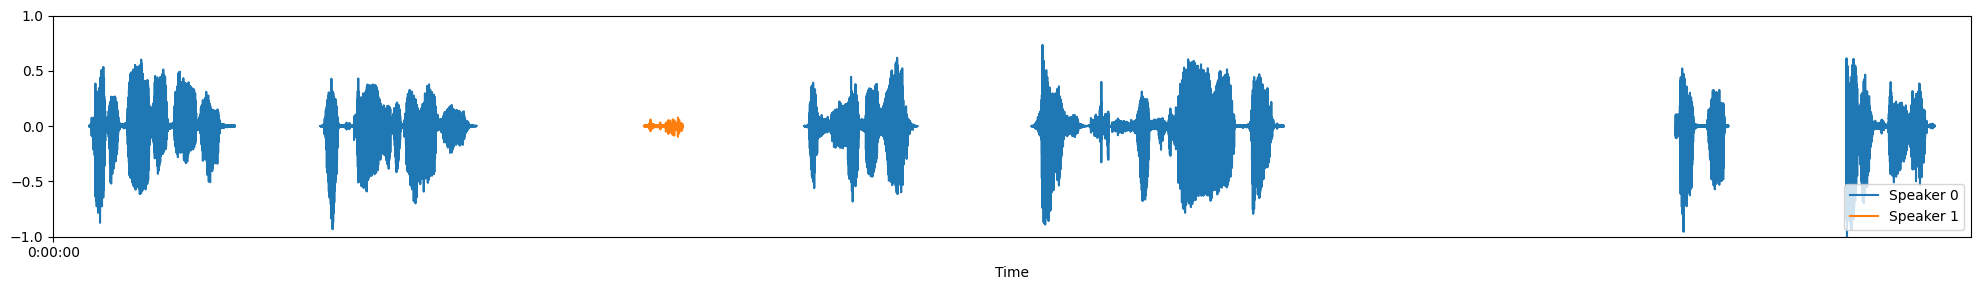

In [167]:
combined_waveplot(signal, fs, segments, figsize=(20,3), tick_interval=60)
plt.show()
Audio(signal.squeeze(), rate=fs)

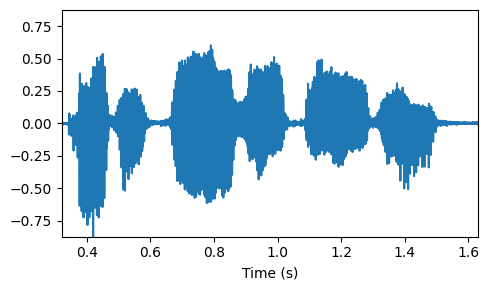

Speaker 0 (0.322s - 1.6299375s)


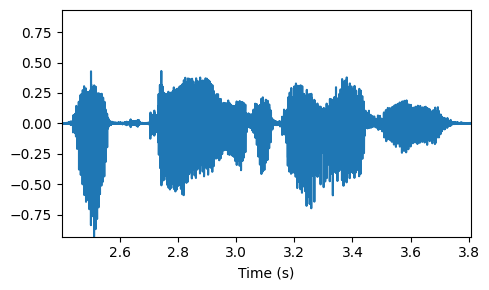

Speaker 0 (2.402s - 3.8059375s)


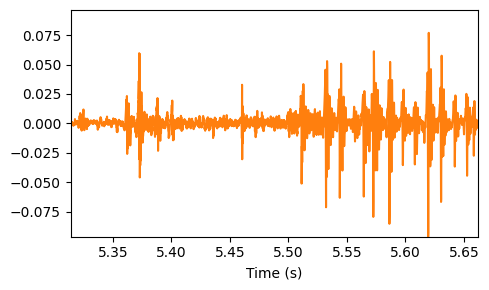

Speaker 1 (5.314s - 5.6619375s)


Exception ignored in: <function Wave_write.__del__ at 0x7a774cc509d0>
Traceback (most recent call last):
  File "/usr/lib/python3.10/wave.py", line 326, in __del__
    self.close()
  File "/usr/lib/python3.10/wave.py", line 444, in close
    self._ensure_header_written(0)
  File "/usr/lib/python3.10/wave.py", line 467, in _ensure_header_written
    self._write_header(datasize)
  File "/usr/lib/python3.10/wave.py", line 471, in _write_header
    self._file.write(b'RIFF')
ValueError: I/O operation on closed file.
Exception ignored in: <function Wave_write.__del__ at 0x7a774cc509d0>
Traceback (most recent call last):
  File "/usr/lib/python3.10/wave.py", line 326, in __del__
    self.close()
  File "/usr/lib/python3.10/wave.py", line 444, in close
    self._ensure_header_written(0)
  File "/usr/lib/python3.10/wave.py", line 467, in _ensure_header_written
    self._write_header(datasize)
  File "/usr/lib/python3.10/wave.py", line 471, in _write_header
    self._file.write(b'RIFF')
ValueErr

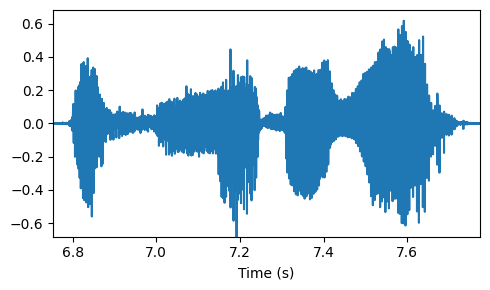

Speaker 0 (6.754s - 7.7739375s)


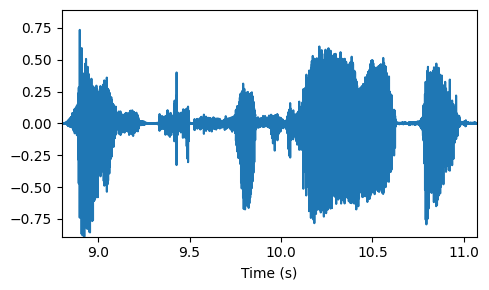

Speaker 0 (8.802s - 11.0699375s)


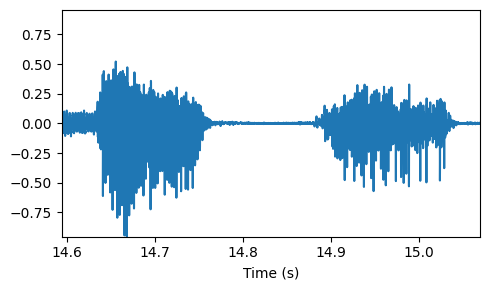

Speaker 0 (14.594s - 15.0699375s)


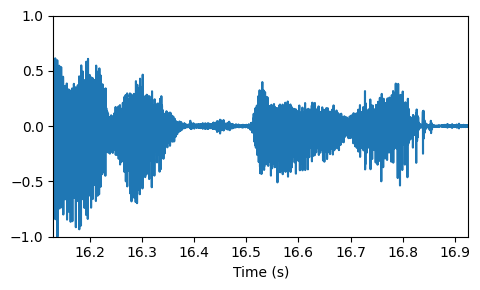

Speaker 0 (16.13s - 16.9259375s)


In [168]:
waveplot_perspeaker(signal, fs, segments)

#### 추출 후 잡음제거

In [169]:
WAV_FILE="/content/drive/MyDrive/졸작/project_share/speechbrain/example_audio/hair_mono.wav"
NUM_SPEAKERS=2

In [170]:
with tempfile.TemporaryDirectory() as outdir:

    signal, fs = sf.read(WAV_FILE)

    print(f"wav file: {WAV_FILE}")

    diar = Diarizer(
        embed_model='xvec', # supported types: ['xvec', 'ecapa']
        cluster_method='ahc', # supported types: ['ahc', 'sc']
        window=1.5, # size of window to extract embeddings (in seconds)
        period=0.75 # hop of window (in seconds)
    )

    # If using NUM_SPEAKERS
    segments = diar.diarize(WAV_FILE,
                            num_speakers=NUM_SPEAKERS,
                            outfile=f"{outdir}.rttm")


    ## If NUM_SPEAKERS is unknown
    # segments = diar.diarize(WAV_FILE,
    #                         num_speakers=None,
    #                         threshold=1e-1,
    #                         outfile=f"{outdir}.rttm")

wav file: /content/drive/MyDrive/졸작/project_share/speechbrain/example_audio/hair_mono.wav


Using cache found in /root/.cache/torch/hub/snakers4_silero-vad_master


Running VAD...
Splitting by silence found 8 utterances
Extracting embeddings...


Utterances:   0%|          | 0/8 [00:00<?, ?it/s]

Clustering to 2 speakers...
Cleaning up output...
Done!


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


In [173]:
segments

[{'start': 0.29,
  'end': 1.8219375,
  'label': 1,
  'start_sample': 4640,
  'end_sample': 29151},
 {'start': 2.402,
  'end': 4.1259375,
  'label': 1,
  'start_sample': 38432,
  'end_sample': 66015},
 {'start': 6.786,
  'end': 8.3499375,
  'label': 1,
  'start_sample': 108576,
  'end_sample': 133599},
 {'start': 8.802,
  'end': 11.5819375,
  'label': 1,
  'start_sample': 140832,
  'end_sample': 185311},
 {'start': 11.874,
  'end': 13.5659375,
  'label': 0,
  'start_sample': 189984,
  'end_sample': 217055},
 {'start': 14.434,
  'end': 17.2559375,
  'label': 1,
  'start_sample': 230944,
  'end_sample': 276095}]

세그먼트 화자별로 색깔 입혀서 출력


대사
```
Ron Burgundy:"Now before we do this, let's go over the ground rules. Rule number 1, no touching of the hair or face!"
Arturo Mendes:"Of course!"
Ron Burgundy:"And that's it! Now let's do this!"
```



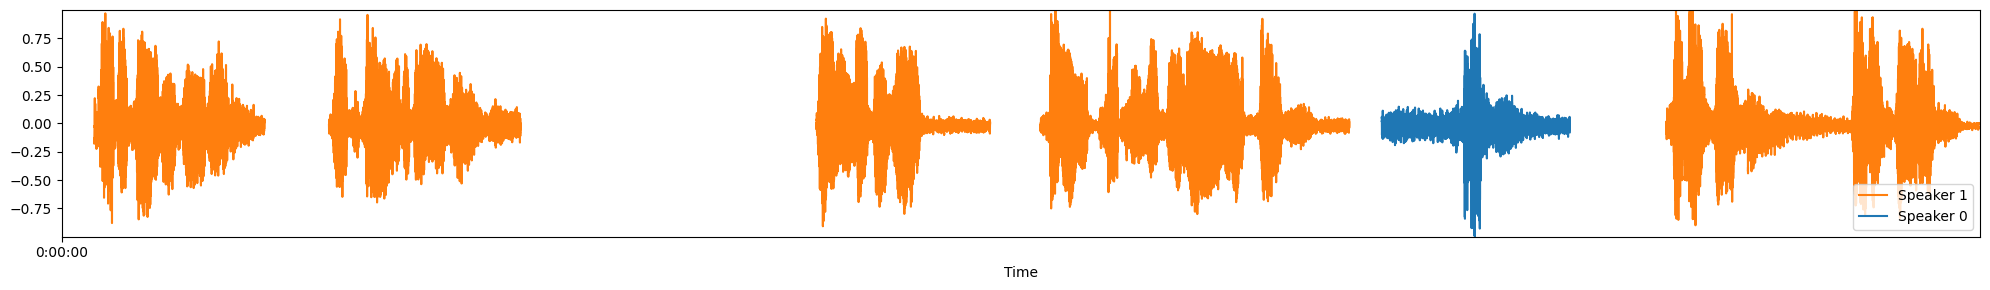

In [171]:
combined_waveplot(signal, fs, segments, figsize=(20,3), tick_interval=60)
plt.show()
Audio(signal.squeeze(), rate=fs)

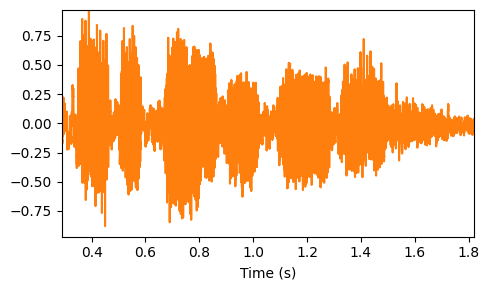

Speaker 1 (0.29s - 1.8219375s)


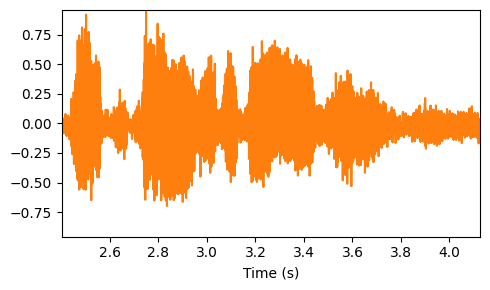

Speaker 1 (2.402s - 4.1259375s)


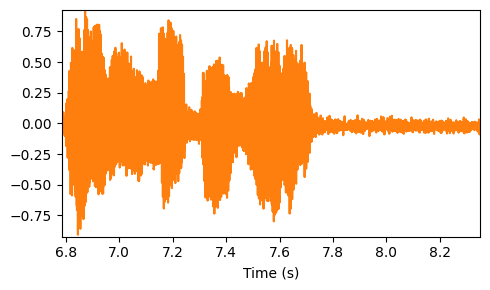

Speaker 1 (6.786s - 8.3499375s)


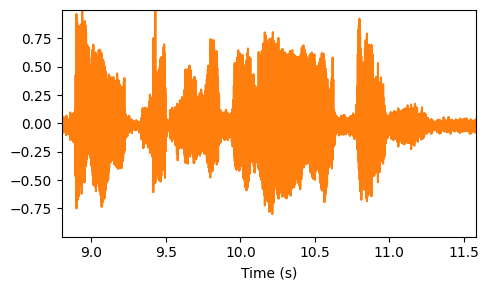

Speaker 1 (8.802s - 11.5819375s)


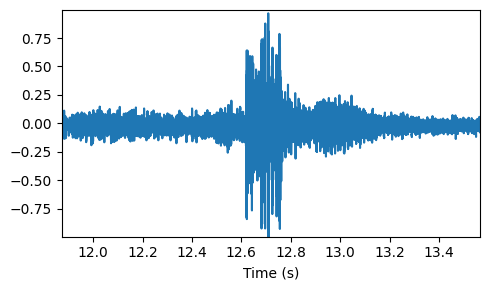

Speaker 0 (11.874s - 13.5659375s)


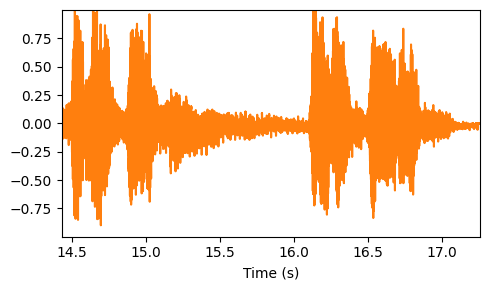

Speaker 1 (14.434s - 17.2559375s)


In [172]:
waveplot_perspeaker(signal, fs, segments)

### 화자 구간 별로 파일 나눠서 저장하는 코드

- 오류가 너무 많이 남.... 실패

In [ ]:
import torch

label = 99999
start_sample = 0
end_sample = 0
output_file_num = 0

for segment in segments:
    if label == segment['label']:
        end_sample = segment['end_sample']
        continue
    if label < 999 or len(segments) == segments.index(segment):
        save_audio = torch.tensor(signal[start_sample:end_sample + 1].squeeze())
        try:
          torchaudio.save(f"/content/drive/MyDrive/졸작/project_share/speechbrain/hiar_segment_audio_{output_file_num}.wav", save_audio, sample_rate=fs)
        except Exception as e:
          print(f"Error saving audio: {e}")
        output_file_num += 1
    label = segment['label']
    start_sample = segment['start_sample']
    end_sample = segment['end_sample']
